In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
# model dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Create connection to remote MySQL database
hostname = "gator3228.hostgator.com"
username = "rbrennan_sm_jb"
password = "This_is_not_the_password"
database = "rbrennan_stock_project_4"
# Create a database connection
db_url = f"mysql+mysqlconnector://{username}:{password}@{hostname}/{database}"
engine = create_engine(db_url)
# Test the connection
try:
    conn = engine.connect()
    print("Connected to MySQL database")
except Exception as e:
    print("Error:", e)
netflix_df = pd.read_sql("SELECT * FROM Netflix", conn)

netflix_df.head()

Connected to MySQL database


,Date,Open,High,Low,Close,Volume
0,2018-02-20,277.739990,285.809998,276.609985,278.549988,7769000
1,2018-02-21,282.070007,286.640015,280.010010,281.040009,9371100
2,2018-02-22,283.880005,284.500000,274.450012,278.140015,8891500
3,2018-02-23,281.000000,286.000000,277.809998,285.929993,7301800
4,2018-02-26,288.750000,295.649994,287.010010,294.160004,10268600


In [3]:
# Set date column as the index
netflix_df.set_index('Date', inplace=True)

netflix_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-02-20,277.739990,285.809998,276.609985,278.549988,7769000
2018-02-21,282.070007,286.640015,280.010010,281.040009,9371100
2018-02-22,283.880005,284.500000,274.450012,278.140015,8891500
2018-02-23,281.000000,286.000000,277.809998,285.929993,7301800
2018-02-26,288.750000,295.649994,287.010010,294.160004,10268600


In [4]:
# Obtain info on DF columns
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1404 entries, 2018-02-20 to 2023-09-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1404 non-null   float64
 1   High    1404 non-null   float64
 2   Low     1404 non-null   float64
 3   Close   1404 non-null   float64
 4   Volume  1404 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 65.8 KB


In [5]:
# Investigate correlation between target (Close) and features
netflix_df.corr()['Close'].sort_values(ascending=False)

Close     1.000000
High      0.998810
Low       0.998763
Open      0.997259
Volume   -0.356505
Name: Close, dtype: float64

<Axes: >

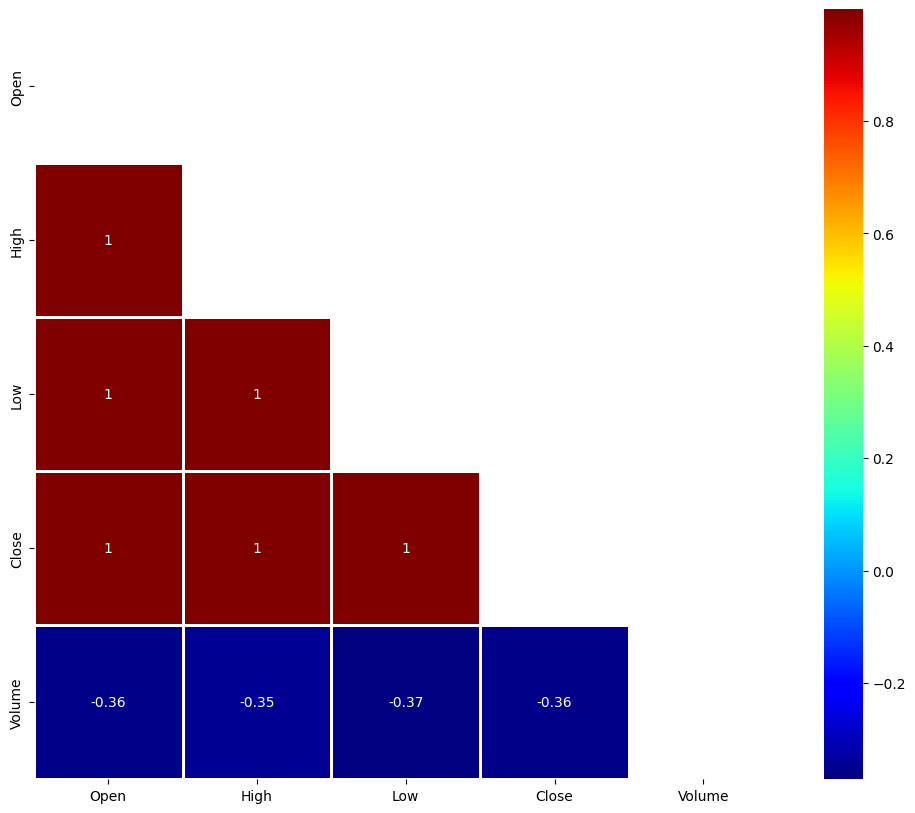

In [6]:
# Heatmap viz of correlations
plt.figure(figsize=(12,10))
mask = np.zeros_like(netflix_df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=netflix_df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [7]:
# MODEL PREPERATION AND TRAINING
X = netflix_df.drop('Close', axis=1)#.values
y = netflix_df['Close']#.values

print(X)
print(y)

                  Open        High         Low    Volume
Date                                                    
2018-02-20  277.739990  285.809998  276.609985   7769000
2018-02-21  282.070007  286.640015  280.010010   9371100
2018-02-22  283.880005  284.500000  274.450012   8891500
2018-02-23  281.000000  286.000000  277.809998   7301800
2018-02-26  288.750000  295.649994  287.010010  10268600
...                ...         ...         ...       ...
2023-09-12  442.850006  445.440002  434.119995   3124000
2023-09-13  435.500000  438.399994  410.690002  11843000
2023-09-14  410.399994  411.390015  400.000000  10709000
2023-09-15  401.000000  404.700012  395.029999   9110700
2023-09-18  395.500000  399.470001  392.600006   4704700

[1404 rows x 4 columns]
Date
2018-02-20    278.549988
2018-02-21    281.040009
2018-02-22    278.140015
2018-02-23    285.929993
2018-02-26    294.160004
                 ...    
2023-09-12    434.690002
2023-09-13    412.239990
2023-09-14    400.489990
2023

In [8]:
# Split the data for training as testing 
# Testing initially set to 20% of data 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False,random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Save dates into Var
train_dates = X_train.index
test_dates = X_test.index

(1123, 4)
(281, 4)
(1123,)
(281,)


In [9]:
# Scaling the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)
print(X_test)

[[-1.07908334 -1.05642746 -1.04054344 -0.02155508]
 [-1.04195529 -1.04935485 -1.01113783  0.2091491 ]
 [-1.02643533 -1.06759002 -1.05922428  0.14008616]
 ...
 [-1.55051337 -1.54732518 -1.52253223 -0.22426544]
 [-1.533107   -1.54817721 -1.50921338 -0.2185918 ]
 [-1.50832649 -1.51434863 -1.4864674  -0.11174298]]
[[-1.52873389 -1.54374636 -1.50532151 -0.34257675]
 [-1.50995555 -1.43007544 -1.47470523  0.44113488]
 [-1.47454265 -1.51324098 -1.48992694 -0.25020004]
 ...
 [ 0.05841967  0.01364618  0.02661295  0.40180818]
 [-0.02218127 -0.04335967 -0.01637082  0.17165121]
 [-0.06934143 -0.08792486 -0.03738697 -0.46281768]]


## Keras Tuner code cells are commented out after hyperparameters were discovered, they are expressed in model layer building cell below

In [10]:
# # Create a method that creates a new Sequential model with hyperparameter options
# def create_model(hp):
#     art_nnet = Sequential()

#     # Allow kerastuner to decide which activation function to use in hidden layers
#     activation = hp.Choice('activation',['relu','tanh'])
    
#     # Allow kerastuner to decide number of neurons in first layer
#     art_nnet.add(Dense(units=hp.Int('first_units',
#         min_value=1,
#         max_value=30,
#         step=5), activation=activation, input_dim=4))

#     # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
#     for i in range(hp.Int('num_layers', 1, 5)):
#         art_nnet.add(Dense(units=hp.Int('units_' + str(i),
#             min_value=1,
#             max_value=30,
#             step=5),
#             activation=activation))
    
#     art_nnet.add(Dense(units=1))

#     # Compile the model
#     art_nnet.compile(loss="mean_squared_error", optimizer='adam')
    
#     return art_nnet

In [11]:
# # Import the kerastuner library
# import keras_tuner as kt

# tuner = kt.RandomSearch(
#     create_model,
#     objective=kt.Objective("loss", direction="min"),  # "val_loss", direction= "min"
#     #max_epochs=20,
#     overwrite=True,
#     max_trials=20)
#     #hyperband_iterations=2)

In [12]:
# # Run the kerastuner search for best hyperparameters
# tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Trial 20 Complete [00h 00m 09s]
loss: 174636.359375

Best loss So Far: 1816.1513671875
Total elapsed time: 00h 03m 22s
INFO:tensorflow:Oracle triggered exit


In [14]:
# art_nnet = tuner.get_best_models()[0]
# art_nnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 30        
                                                                 
 dense_1 (Dense)             (None, 11)                77        
                                                                 
 dense_2 (Dense)             (None, 21)                252       
                                                                 
 dense_3 (Dense)             (None, 6)                 132       
                                                                 
 dense_4 (Dense)             (None, 16)                112       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 620 (2.42 KB)
Trainable params: 620 (2.42 

In [15]:
# Define the best paramaters defined by the tuner
# best_params = tuner.get_best_hyperparameters()
# best_params[0].values

{'activation': 'relu',
 'first_units': 6,
 'num_layers': 4,
 'units_0': 11,
 'units_1': 21,
 'units_2': 6,
 'units_3': 16,
 'units_4': 21}

In [17]:
# Define Artificial Neural Net
art_nnet = Sequential()

# Adding First Hidden Layer
art_nnet.add(Dense(units=6, activation="relu")) 

# Adding Second Hidden Layer 
art_nnet.add(Dense(units=11, activation="relu"))

# Adding Third Hidden Layer
art_nnet.add(Dense(units=21, activation="relu")) 

# Adding Fourth Hidden Layer
art_nnet.add(Dense(units=6, activation="relu")) 

# Adding Fifth Hidden Layer
art_nnet.add(Dense(units=16, activation="relu"))

# Output Layer
art_nnet.add(Dense(units=1))

In [18]:
# Compiling the model
art_nnet.compile(optimizer="adam",loss="mean_squared_error")

In [19]:
# Train the model 
art_nnet.fit(x=X_train, y=y_train, epochs=100, batch_size=32,validation_data=(X_test,y_test) \
             ,callbacks=EarlyStopping(monitor='val_loss',patience=4))

Epoch 1/100
36/36 [==============================] - 2s 13ms/step - loss: 176327.0938 - val_loss: 115709.9922
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 175996.2969 - val_loss: 115198.1094
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 175027.6875 - val_loss: 113488.8516
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 171729.7031 - val_loss: 107970.8594
Epoch 5/100
36/36 [==============================] - 0s 4ms/step - loss: 161403.0938 - val_loss: 92620.0391
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 135285.2656 - val_loss: 63224.8047
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 93087.9844 - val_loss: 44928.8203
Epoch 8/100
36/36 [==============================] - 0s 5ms/step - loss: 57873.9102 - val_loss: 39257.1016
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 34192.4141 - val_loss: 29086.4395
Epoch 10/100
36/36 [======

In [20]:
# Evaluating the loss 
loss_history = pd.DataFrame(art_nnet.history.history)
loss_history

,loss,val_loss
0,176327.093750,115709.992188
1,175996.296875,115198.109375
2,175027.687500,113488.851562
3,171729.703125,107970.859375
4,161403.093750,92620.039062
...,...,...
95,71.989059,37.706264
96,70.348534,34.458916
97,70.821922,34.608562
98,68.637871,33.978432


Text(0, 0.5, 'Loss')

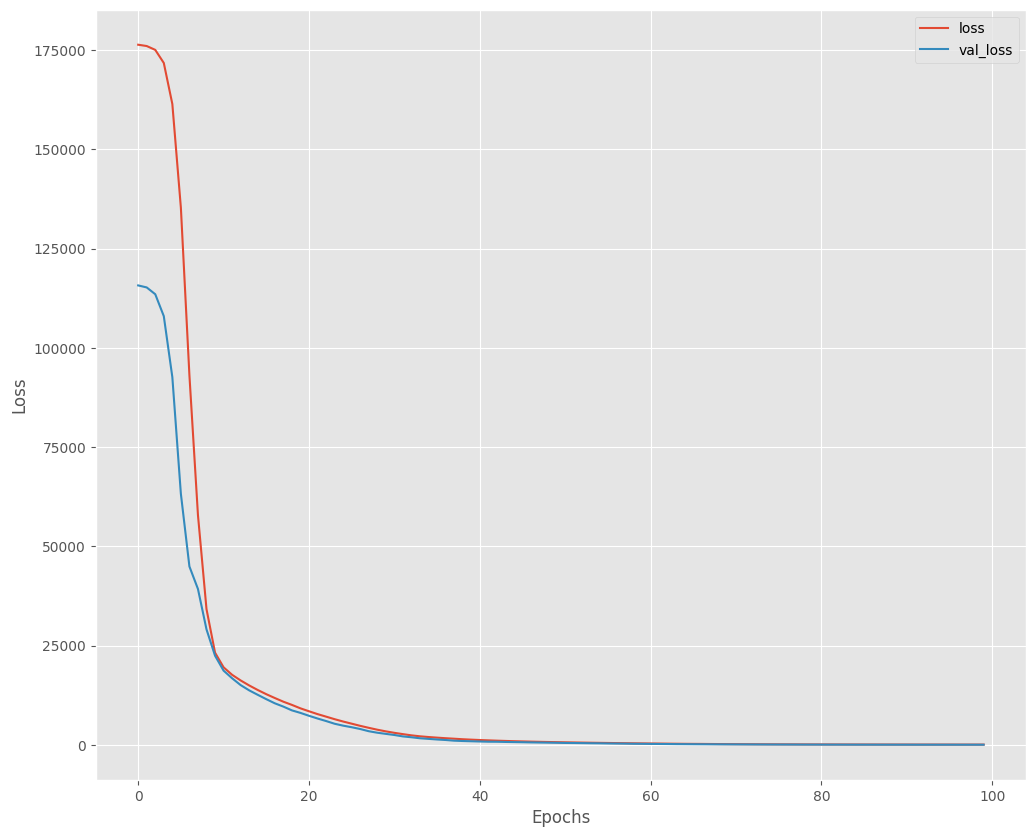

In [21]:
# Visualize the loss DF above 
plt.style.use("ggplot")
pd.DataFrame(art_nnet.history.history).plot(figsize=(12,10))
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [22]:
# Evaluate the Training & Testing 
print(f'Training Evaluation: {art_nnet.evaluate(X_train, y_train)}')
print(f'Testing Evaluation: {art_nnet.evaluate(X_test, y_test)}')

36/36 [==============================] - 0s 2ms/step - loss: 66.6535
Training Evaluation: 66.65352630615234
9/9 [==============================] - 0s 2ms/step - loss: 33.4016
Testing Evaluation: 33.40160369873047


In [25]:
y_test

Date
2022-08-05    226.779999
2022-08-08    233.490005
2022-08-09    229.940002
2022-08-10    244.110001
2022-08-11    242.699997
                 ...    
2023-09-12    434.690002
2023-09-13    412.239990
2023-09-14    400.489990
2023-09-15    396.940002
2023-09-18    394.399994
Name: Close, Length: 281, dtype: float64

In [32]:
# Make Predictions 
ann_predictions = art_nnet.predict(X_test)
predictions_df = pd.DataFrame(np.ravel(ann_predictions),columns=["Predictions"])
comparison_df = pd.concat([pd.DataFrame(y_test.values,columns=["Real Values"]), predictions_df],axis=1)
comparison_df

9/9 [==============================] - 0s 2ms/step


,Real Values,Predictions
0,226.779999,228.069687
1,233.490005,237.008331
2,229.940002,232.969559
3,244.110001,240.326828
4,242.699997,248.306335
...,...,...
276,434.690002,441.900818
277,412.239990,435.533600
278,400.489990,404.558289
279,396.940002,397.122559


In [24]:
# Check shapes of test-target and predictions 
print(y_test.shape)
print(ann_predictions.shape)

(281,)
(281, 1)


c:\Users\justi\anaconda3\envs\tensorflow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\justi\anaconda3\envs\tensorflow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Actual Values')

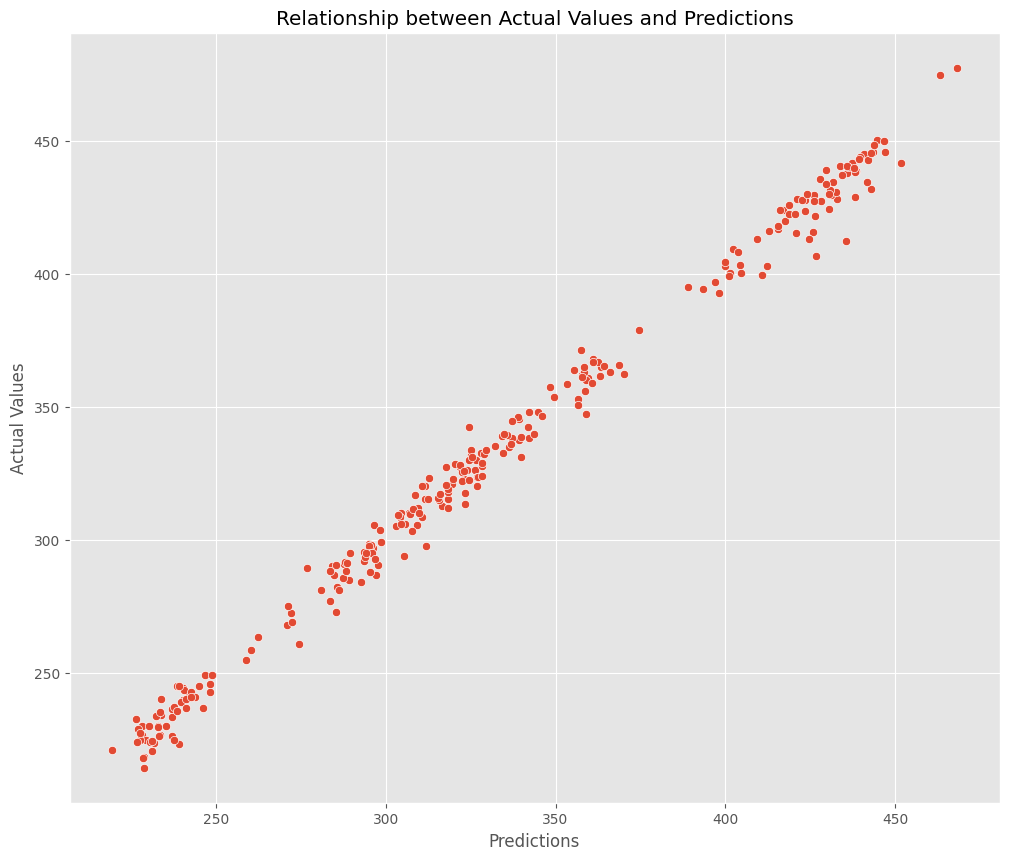

In [26]:
# Visualize test values against predictions
plt.figure(figsize=(12,10))
sns.scatterplot(x=np.ravel(ann_predictions),y=y_test)
plt.title("Relationship between Actual Values and Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")

In [27]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
# Evaluate the model performance with the residual of squares and the explained variance score

# Mean Absolute Error
print("MAE:",metrics.mean_absolute_error(y_test,ann_predictions))
# Mean Squared Error
print ("MSE:",metrics.mean_squared_error(y_test,ann_predictions))
# Square Root of MSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,ann_predictions)))
# Explained Variance Score, which shows how correctly the model predicts the target as a %, the closer to 100% the better
print("EVS:",metrics.explained_variance_score(y_test,ann_predictions))

MAE: 4.442287722694478
MSE: 33.40160276831247
RMSE: 5.779411974268012
EVS: 0.9931819669428037


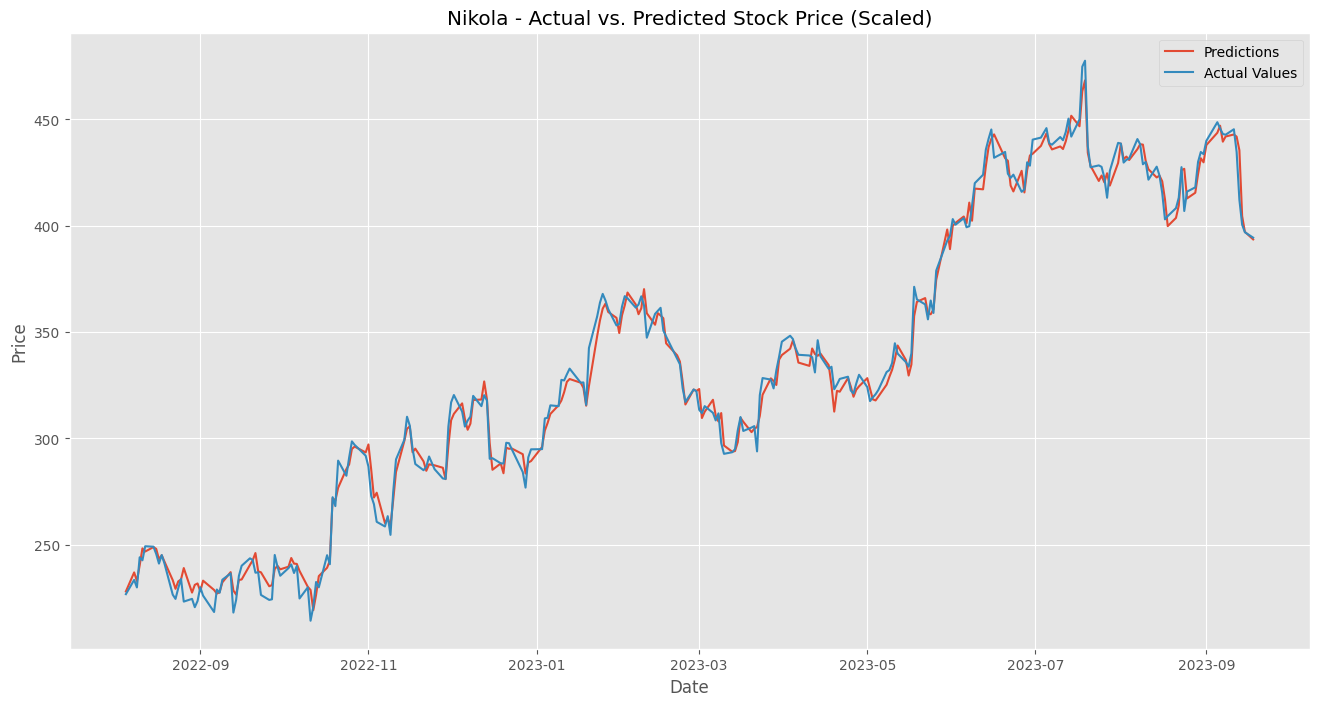

In [28]:
# Visualize Predictions vs Actual Stock prices 
plt.figure(figsize=(16,8))
plt.plot(test_dates, ann_predictions, label='Predictions')
plt.plot(test_dates, y_test, label='Actual Values')
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Nikola - Actual vs. Predicted Stock Price (Scaled)')
plt.show()